In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.auto import trange, tqdm
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *

In [5]:
import os
import pickle as pkl
from circuit_toolkit.plot_utils import saveallforms
saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

### Training Demo

  0%|          | 0/2000 [00:00<?, ?it/s]

step 0 loss 1.679


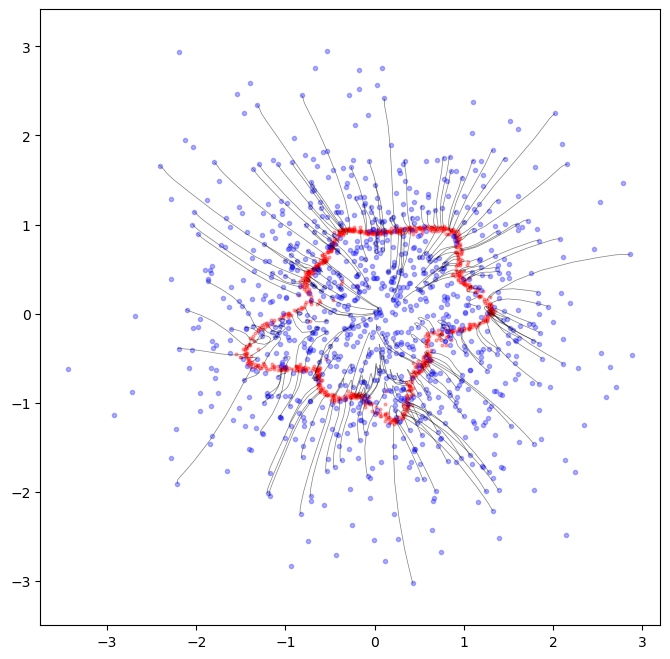

In [6]:
pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=2, nlayers=5, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=2000, batch_size=1024, device=device)

noise_init = torch.randn(1000, 2).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8,8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3)
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3)
plt.axis("equal")
plt.show()

### Gaussian Data Spectral convergence

In [7]:
!mkdir $STORE_DIR/DL_Projects/DiffusionSpectralLearningCurve

In [8]:
!echo $STORE_DIR/DL_Projects/DiffusionSpectralLearningCurve

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve


/tmp/ipykernel_556610/697652613.py:24: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]


True covariance trace 128.00001525878906
Estimated training sample covariance trace 128.32379150390625


  0%|          | 0/1000 [00:00<?, ?it/s]

step 0 loss 2.623


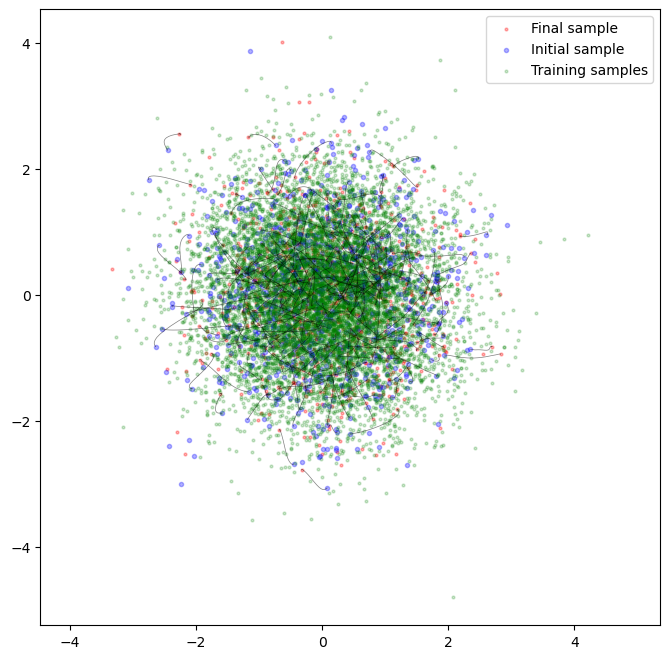

In [12]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

# pnts, radius_fun, amplitudes, phases = generate_random_star_shape_torch(1000, num_modes=10)
# create a 10 x 10 covariance matrix with non white spectrum
ndim = 128
savedir = f"{saveroot}/GaussianData/ndim{ndim}"
os.makedirs(savedir, exist_ok=True)
device = get_device()
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rot = torch.eye(ndim, device=device)
# rotate the covariance matrix with a random rotation matrix
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
cov_empirical = torch.cov(pnts.T, correction=1)
print("True covariance trace", torch.trace(cov).item()) # ~ 10
print("Estimated training sample covariance trace", torch.trace(cov_empirical).item()) # ~ 13.2

pnts = pnts.float()
device = get_device()
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=5, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=1000, batch_size=1024, device=device, 
                                    callback=sampling_callback_fn, callback_freq=5)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()

pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

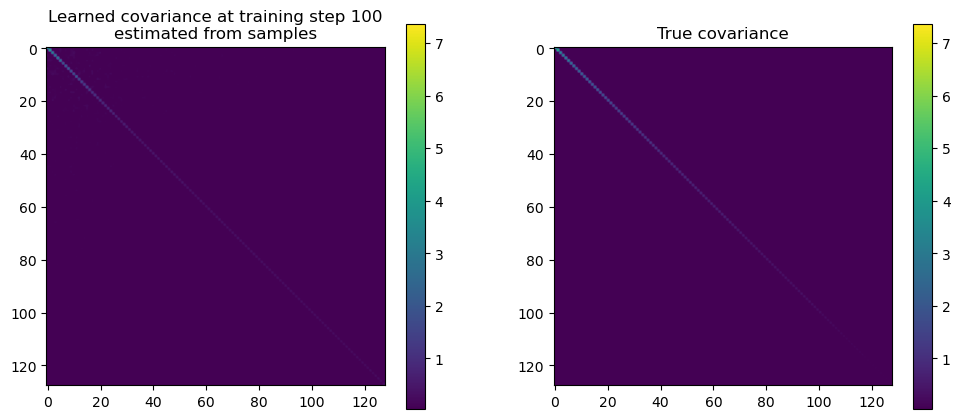

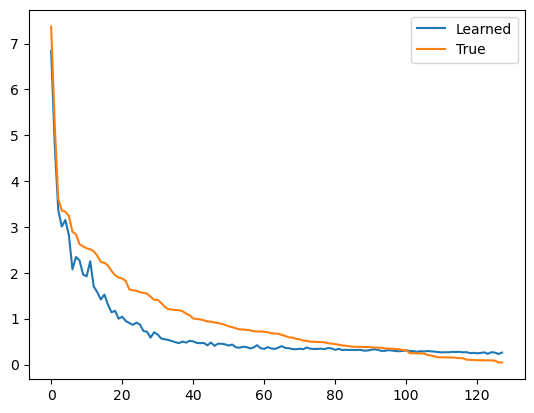

In [188]:
training_step = 100
x_traj, x0hat_traj, t_steps = sample_store[training_step]
cov_x_sample = torch.cov(x_traj[-1].T).to(device)
# try estimate the variance along the eigenvector of the covariance matrix
cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
cov_true_eigenbasis = rot.T @ cov @ rot
diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
diag_cov_true_eigenbasis = torch.diag(cov_true_eigenbasis)

vmin = min(diag_cov_x_sample_true_eigenbasis.min(), diag_cov_true_eigenbasis.min())
vmax = max(diag_cov_x_sample_true_eigenbasis.max(), diag_cov_true_eigenbasis.max())
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(cov_x_sample_true_eigenbasis.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Learned covariance at training step {training_step}\nestimated from samples")
plt.subplot(122)
plt.imshow(cov_true_eigenbasis.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("True covariance")
plt.show()
plt.plot(diag_cov_x_sample_true_eigenbasis.cpu().numpy(), label="Learned")
plt.plot(diag_cov_true_eigenbasis.cpu().numpy(), label="True")
plt.legend()
plt.show()

In [21]:
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in step_slice:
    x_traj, x0hat_traj, t_steps = sample_store[training_step]
    cov_x_sample = torch.cov(x_traj[-1].T).to(device)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    cov_true_eigenbasis = rot.T @ cov @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_true_eigenbasis = torch.diag(cov_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis)
    
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

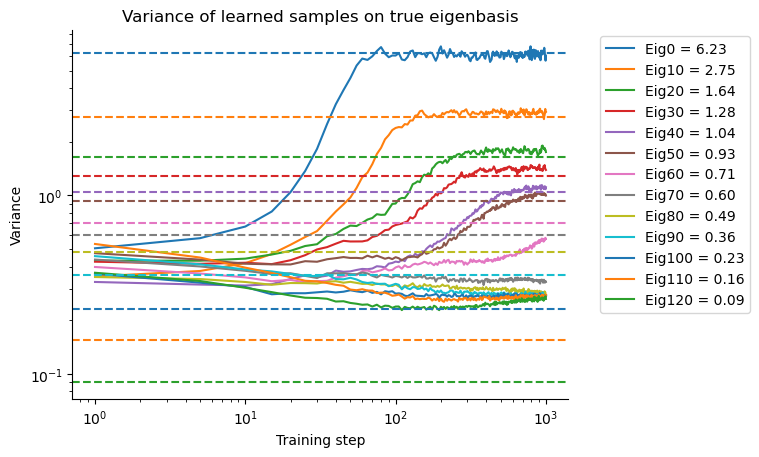

In [22]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, None, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot])
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw")
plt.show()

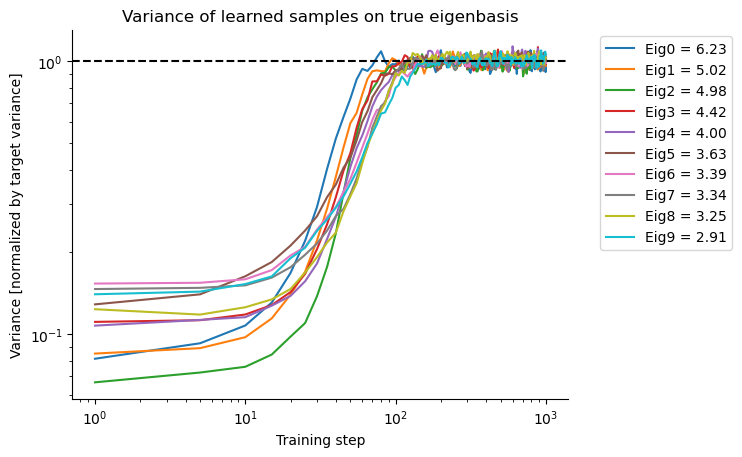

In [27]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj.numpy() / true_cov_eigs.numpy())
slice2plot = slice(None, 10, 1)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot])
plt.axhline(1, color="k", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top10")
plt.show()

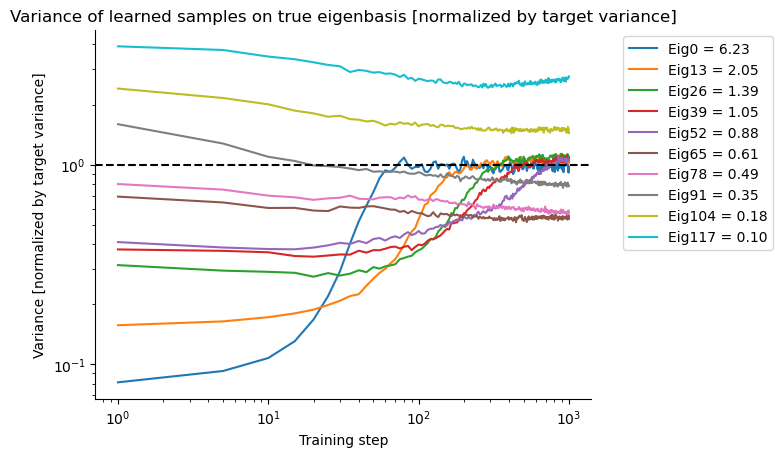

In [29]:
true_cov_eigs = diag_cov_true_eigenbasis.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs).numpy()
slice2plot = slice(None, None, 13)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], )
plt.axhline(1, color="k", linestyle="--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis [normalized by target variance]")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_every10")
plt.show()

### MNIST

In [207]:
!echo $STORE_DIR/Datasets

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets


In [30]:
import torchvision
import torchvision.transforms as transforms
# load MNIST dataset, make it a B x 28 x 28 tensor
mnist_dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                                           train=True, download=True, transform=transforms.ToTensor())
mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
print(mnist_Xtsr.shape) # 60000 x 28 x 28

torch.Size([60000, 1, 28, 28])


In [58]:
savedir = f"{saveroot}/MNIST_MLP_EDM"
os.makedirs(savedir, exist_ok=True)

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
X_mean = pnts.mean(dim=0)
cov_empirical = torch.cov(pnts.T, correction=1)
# diagonalize the covariance matrix
cov_empirical_eigs, cov_empirical_evecs = torch.linalg.eigh(cov_empirical)
cov_empirical_eigs = cov_empirical_eigs.flip(0)
cov_empirical_evecs = cov_empirical_evecs.flip(1)
rot = cov_empirical_evecs
diag_var = cov_empirical_eigs
assert torch.allclose(rot @ torch.diag(diag_var) @ rot.T, cov_empirical, atol=5e-5)
pkl.dump({"diag_var": diag_var.cpu(), 
          "rot": rot.cpu(), 
          #   "cov": cov.cpu(), 
          "cov_empirical": cov_empirical.cpu(),
          "X_mean": X_mean.cpu(),
          "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

MNIST dataset 60000 samples, 784 features


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0 loss 2.765


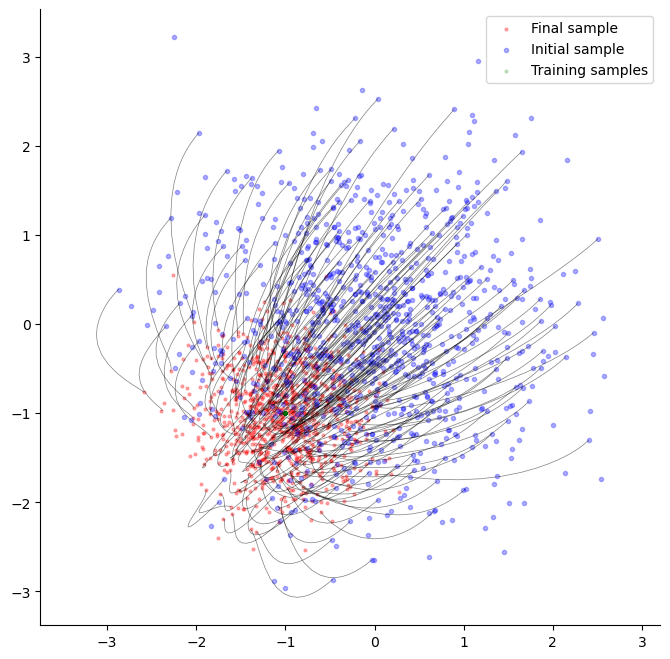

In [59]:
sample_store = {}
loss_store = {}
def sampling_callback_fn(epoch, loss, model):
    loss_store[epoch] = loss
    noise_init = torch.randn(10000, ndim).to(device)
    x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model, noise_init, 
                    num_steps=20, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)
    sample_store[epoch] = x_out.cpu(), # x_traj.cpu(), x0hat_traj.cpu(), t_steps.cpu()

device = get_device()
pnts = mnist_Xtsr.view(mnist_Xtsr.shape[0], -1).to(device)
pnts = (pnts - 0.5) / 0.5
ndim = pnts.shape[1]
cov_empirical = torch.cov(pnts.T, correction=1)
print(f"MNIST dataset {pnts.shape[0]} samples, {ndim} features")
model = UNetBlockStyleMLP_backbone(ndim=ndim, nlayers=8, nhidden=64, time_embed_dim=64,)
model_precd = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
edm_loss_fn = EDMLoss(P_mean=-1.2, P_std=1.2, sigma_data=0.5)
model_precd, loss_traj = train_score_model_custom_loss(pnts, model_precd, edm_loss_fn, 
                                    lr=0.001, nepochs=5000, batch_size=2048, device=device, 
                                    callback=sampling_callback_fn, callback_freq=5)

noise_init = torch.randn(1000, ndim).to(device)
x_out, x_traj, x0hat_traj, t_steps = edm_sampler(model_precd, noise_init, 
                num_steps=40, sigma_min=0.002, sigma_max=80, rho=7, return_traj=True)

scaling = 1 / (t_steps ** 2 + 1).sqrt()
scaled_x_traj = (scaling[:, None, None] * x_traj).cpu()
plt.figure(figsize=[8, 8])
plt.plot(scaled_x_traj[:, ::4, 0].numpy(), 
        scaled_x_traj[:, ::4, 1].numpy(), lw=0.5, color="k", alpha=0.5)
plt.scatter(scaled_x_traj[-1,:,0], scaled_x_traj[-1,:,1], c="red", s=4, marker='o', alpha=0.3, label="Final sample")
plt.scatter(scaled_x_traj[ 0,:,0], scaled_x_traj[ 0,:,1], c="blue", s=9, marker='o', alpha=0.3, label="Initial sample")
plt.scatter(pnts[:,0].cpu(), pnts[:,1].cpu(), c="green", s=4, marker='o', alpha=0.2, label="Training samples")
plt.axis("equal")
plt.legend()
plt.show()

In [60]:
pkl.dump(sample_store, open(f"{savedir}/sample_store.pkl", "wb"))
pkl.dump(loss_store, open(f"{savedir}/loss_store.pkl", "wb"))
torch.save(model_precd.model.state_dict(), f"{savedir}/model_final.pth")
# pkl.dump({"diag_var": diag_var.cpu(), 
#           "rot": rot.cpu(), 
#           "cov": cov.cpu(), 
#           "cov_empirical": cov_empirical.cpu(),
#           "train_pnts": pnts.cpu()}, open(f"{savedir}/train_data_cov_info.pkl", "wb"))

In [94]:
true_cov_eigs = diag_var.cpu()
mean_x_sample_traj = []
cov_x_sample_traj = []
diag_cov_x_sample_true_eigenbasis_traj = []
step_slice = [*sample_store.keys()]
for training_step in tqdm(step_slice):
    x_final, = sample_store[training_step]
    x_final = x_final.to(device)
    mean_x_sample = x_final.mean(dim=0)
    mean_x_sample_traj.append(mean_x_sample.cpu())
    cov_x_sample = torch.cov(x_final.T)
    # try estimate the variance along the eigenvector of the covariance matrix
    cov_x_sample_true_eigenbasis = rot.T @ cov_x_sample @ rot
    diag_cov_x_sample_true_eigenbasis = torch.diag(cov_x_sample_true_eigenbasis)
    diag_cov_x_sample_true_eigenbasis_traj.append(diag_cov_x_sample_true_eigenbasis.cpu())
    cov_x_sample_traj.append(cov_x_sample.cpu())
    
mean_x_sample_traj = torch.stack(mean_x_sample_traj).cpu()
cov_x_sample_traj = torch.stack(cov_x_sample_traj).cpu()
diag_cov_x_sample_true_eigenbasis_traj = torch.stack(diag_cov_x_sample_true_eigenbasis_traj).cpu()

pkl.dump({"diag_cov_x_sample_true_eigenbasis_traj": diag_cov_x_sample_true_eigenbasis_traj.cpu(), 
          "mean_x_sample_traj": mean_x_sample_traj.cpu(),
          "cov_x_sample_traj": cov_x_sample_traj.cpu(),
          "true_cov_eigs": true_cov_eigs.cpu(),
          "step_slice": step_slice}, open(f"{savedir}/sample_cov_true_eigenbasis_diag_traj.pkl", "wb"))

  0%|          | 0/1001 [00:00<?, ?it/s]

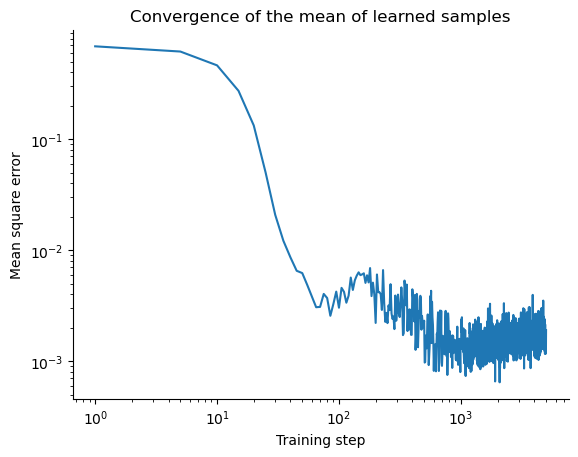

In [75]:
# plot the convergence of the mean 
mean_X_loss = (mean_x_sample_traj.cuda() - X_mean).pow(2).mean(dim=1)
plt.plot(step_slice, mean_X_loss.cpu().numpy(), label="MSE of mean")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Mean square error")
plt.title("Convergence of the mean of learned samples")
saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

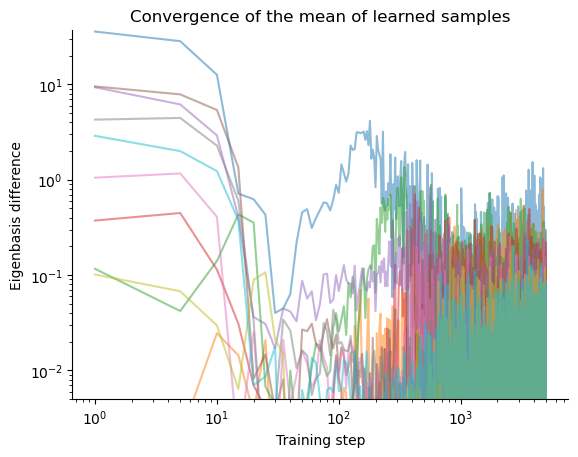

In [87]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
plt.plot(step_slice, mean_X_diff_true_basis.pow(2).cpu().numpy()[:, slice(None, 20, 2)], label="Eigenbasis difference", alpha=0.5)
plt.ylim(5E-3, None)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("Eigenbasis difference")
plt.title("Convergence of the mean of learned samples")
# saveallforms(savedir, "sample_mean_convergence_MSE_traj")
plt.show()

In [89]:
mean_X_diff_true_basis.shape

torch.Size([1001, 784])

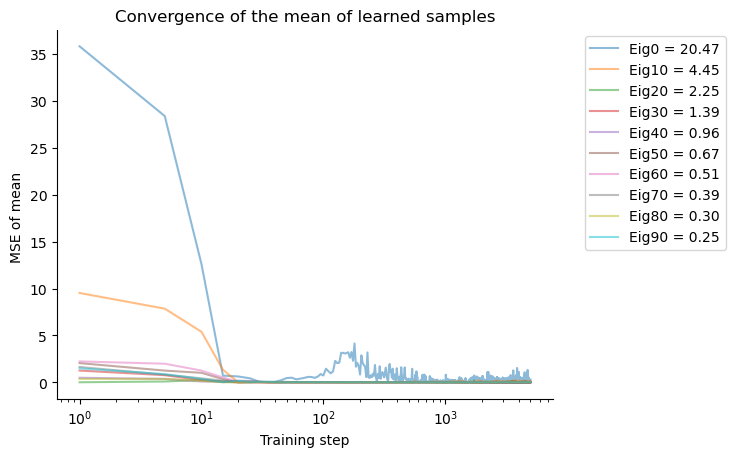

In [93]:
# Project the difference of mean on the true eigenbasis
mean_X_diff_true_basis = (mean_x_sample_traj.cuda() - X_mean) @ rot
MSE_X_diff_true_basis = mean_X_diff_true_basis.pow(2).cpu()
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, MSE_X_diff_true_basis.numpy()[:, slice2plot], label="Eigenbasis difference", alpha=0.5)
plt.xscale("log")
# plt.yscale("log")
plt.xlabel("Training step")
plt.ylabel("MSE of mean ")
plt.title("Convergence of the mean of learned samples")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
saveallforms(savedir, "sample_mean_convergence_eigenbasis_MSE_traj_top100")
plt.show()

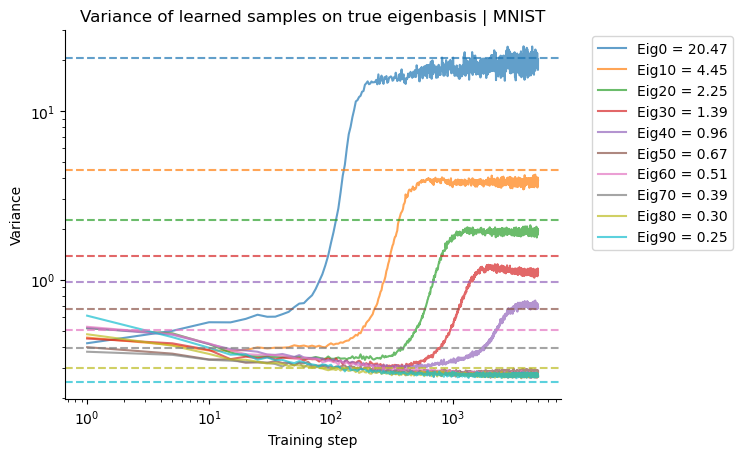

In [68]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_x_sample_true_eigenbasis_traj[:, slice2plot], alpha=0.7)
for i, eigid in enumerate(range(ndim)[slice2plot]):
    plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_raw_top100")
plt.show()

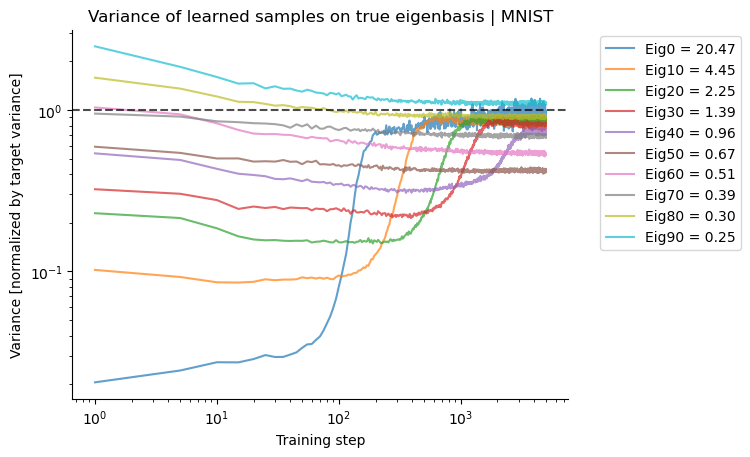

In [82]:
true_cov_eigs = diag_var.cpu()
diag_cov_normalized = (diag_cov_x_sample_true_eigenbasis_traj / true_cov_eigs)
slice2plot = slice(None, 100, 10)
plt.plot(step_slice, diag_cov_normalized[:, slice2plot], alpha=0.7)
plt.axhline(1, color="k", linestyle="--", alpha=0.7)
# for i, eigid in enumerate(range(ndim)[slice2plot]):
#     plt.axhline(true_cov_eigs[eigid].item(), color=f"C{i}", linestyle="--", alpha=0.7)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Training step")
plt.ylabel("Variance [normalized by target variance]")
plt.gca().legend([f"Eig{i} = {true_cov_eigs[i].item():.2f}" for i in range(ndim)[slice2plot]], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Variance of learned samples on true eigenbasis | MNIST")
saveallforms(savedir, "sample_cov_true_eigenbasis_diag_traj_normalized_top100")
plt.show()

#### Dynamic interaction of mean and covariance

### Scratch space

Estimated sample covariance trace 7.940922260284424
True covariance trace 4.999999523162842


Text(0.5, 1.0, 'Learned covariance at training step 2000\nestimated from samples')

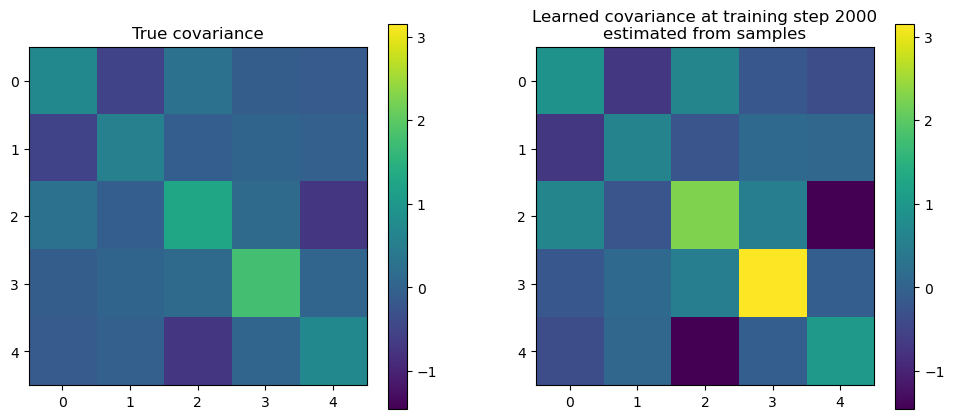

In [ ]:
training_step = 2000
x_traj, x0hat_traj, t_steps = sample_store[training_step]
cov_x_sample = torch.cov(x_traj[-1].T, correction=1) 
print("Estimated sample covariance trace", torch.diag(cov_x_sample).sum().item())
print("True covariance trace", torch.diag(cov).sum().item())
# print(x_traj.shape) # 21 x 10000 x 10
# print(x0hat_traj.shape) # 20 x 10000 x 10
# print(t_steps.shape) # 21

vmin = min(cov.cpu().numpy().min(), cov_x_sample.cpu().numpy().min())
vmax = max(cov.cpu().numpy().max(), cov_x_sample.cpu().numpy().max())
plt.figure(figsize=[12, 5])
plt.subplot(121)
plt.imshow(cov.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title("True covariance")
plt.subplot(122)
plt.imshow(cov_x_sample.cpu().numpy(), vmin=vmin, vmax=vmax)
plt.colorbar()
plt.title(f"Learned covariance at training step {training_step}\nestimated from samples")

In [ ]:
ndim = 10
# diag_var = torch.rand(ndim, device=device)
diag_var = torch.exp(torch.randn(ndim, device=device))
diag_var = torch.sort(diag_var, descending=True)[0]
diag_var = diag_var / diag_var.mean() 
diag_std = diag_var.sqrt()
cov = torch.diag(diag_var)
# rotate the covariance matrix with a random rotation matrix
# rot = torch.eye(ndim, device=device)
rot = torch.qr(torch.randn(ndim, ndim, device=device))[0]
cov = rot @ cov @ rot.T
pnts = torch.randn(10000, ndim).to(device)
pnts = pnts @ torch.diag(diag_std) @ rot.T
print(torch.trace(cov).item()) # ~ 10
print(torch.trace(torch.cov(pnts.T, correction=1)).item()) # ~ 13.2

10.0
10.027811050415039


In [ ]:
training_step = 1000
x_traj, x0hat_traj, t_steps = sample_store[training_step]
print(x_traj.shape) # 21 x 10000 x 10
print(x0hat_traj.shape) # 20 x 10000 x 10
print(t_steps.shape) # 21
# compute the covariance of the samples
cov_x_sample = torch.cov(x_traj[-1].T) 
print(cov_x_sample.shape) # 10 x 10
# compute the covariance of the samples
# cov_x0hat_final = torch.cov(x0hat_traj[-1])
# print(cov_x0hat_final.shape) # 10 x 10

torch.Size([41, 10000, 25])
torch.Size([40, 10000, 25])
torch.Size([41])
torch.Size([25, 25])


In [ ]:
torch.trace(torch.cov(pnts.T))

tensor(7.8858, device='cuda:0')